In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0604/weights_KD_segformer_0604_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.5
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.0133

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - loss: 0.0097
Average validation loss: 0.7136663794517517
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 532ms/step - loss: 0.0097 - val_loss: 0.7137
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 739ms/step - loss: 0.0066 - val_loss: 0.7137
Average validation loss: 0.5417827367782593
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 754ms/step - loss: 0.0066 - val_loss: 0.6277
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 900ms/step - loss: 0.0047 - val_loss: 0.6277
Average validation loss: 0.4051516354084015
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 912ms/step - loss: 0.0047 - val_loss: 0.5535
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_seg

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 832ms/step - loss: 4.5579e-06
Average validation loss: 0.2108805924654007
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 846ms/step - loss: 4.5579e-06 - val_loss: 0.2109
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 797ms/step - loss: 4.5790e-06 - val_loss: 0.2109
Average validation loss: 0.17868270352482796
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 811ms/step - loss: 4.5790e-06 - val_loss: 0.1948
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 766ms/step - loss: 4.0724e-06 - val_loss: 0.1948
Average validation loss: 0.15018944442272186
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 780ms/step - loss: 4.0724e-06 - val_loss: 0.1799
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 926ms/step - loss: 1.5144e-06
Average validation loss: 0.09533784538507462
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 935ms/step - loss: 1.5144e-06 - val_loss: 0.0953
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 845ms/step - loss: 1.3134e-06 - val_loss: 0.0953
Average validation loss: 0.062187874068816505
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 856ms/step - loss: 1.3134e-06 - val_loss: 0.0788
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 847ms/step - loss: 1.1274e-06 - val_loss: 0.0788
Average validation loss: 0.02499026743074258
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 860ms/step - loss: 1.1274e-06 - val_loss: 0.0608
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\we

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 767ms/step - loss: 3.6837e-07
Average validation loss: 0.017885114531964064
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 781ms/step - loss: 3.6837e-07 - val_loss: 0.0179
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 802ms/step - loss: 3.5721e-07 - val_loss: 0.0179
Average validation loss: 0.02166594297159463
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 815ms/step - loss: 3.5721e-07 - val_loss: 0.0198
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 818ms/step - loss: 3.1687e-07 - val_loss: 0.0198
Average validation loss: 0.01720155798830092
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 831ms/step - loss: 3.1687e-07 - val_loss: 0.0189
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_20.pth'.
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 51s 761ms/step - loss: 2.9734

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 835ms/step - loss: 4.0484e-07
Average validation loss: 0.020485228532925247
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 845ms/step - loss: 4.0484e-07 - val_loss: 0.0205
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 832ms/step - loss: 3.9707e-07 - val_loss: 0.0205
Average validation loss: 0.025155177805572748
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 841ms/step - loss: 3.9707e-07 - val_loss: 0.0228
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 835ms/step - loss: 3.2192e-07 - val_loss: 0.0228
Average validation loss: 0.01819145679473877
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 846ms/step - loss: 3.2192e-07 - val_loss: 0.0213
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_25.pth'.
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 779ms/step - loss: 2.780

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 856ms/step - loss: 4.3594e-07
Average validation loss: 0.02433048856134216
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 865ms/step - loss: 4.3594e-07 - val_loss: 0.0243
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 849ms/step - loss: 3.7249e-07 - val_loss: 0.0243
Average validation loss: 0.013946764559174577
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 860ms/step - loss: 3.7249e-07 - val_loss: 0.0191
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 60s 792ms/step - loss: 3.2786e-07 - val_loss: 0.0191
Average validation loss: 0.011167472616458932
24/24 ━━━━━━━━━━━━━━━━━━━━ 61s 802ms/step - loss: 3.2786e-07 - val_loss: 0.0165
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\w

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 920ms/step - loss: 7.2743e-07
Average validation loss: 0.02934260293841362
40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 933ms/step - loss: 7.2743e-07 - val_loss: 0.0293
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 68s 777ms/step - loss: 5.3677e-07 - val_loss: 0.0293
Average validation loss: 0.023122041160240768
40/40 ━━━━━━━━━━━━━━━━━━━━ 69s 789ms/step - loss: 5.3677e-07 - val_loss: 0.0262
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 100s 776ms/step - loss: 4.3361e-07 - val_loss: 0.0262
Average validation loss: 0.020895003783516587
40/40 ━━━━━━━━━━━━━━━━━━━━ 100s 789ms/step - loss: 4.3361e-07 - val_loss: 0.0245
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 779ms/step - loss: 3.2980e-07
Average validation loss: 0.01867816868859033
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 791ms/step - loss: 3.2980e-07 - val_loss: 0.0187
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 76s 788ms/step - loss: 2.4891e-07 - val_loss: 0.0187
Average validation loss: 0.012766961105323086
48/48 ━━━━━━━━━━━━━━━━━━━━ 76s 800ms/step - loss: 2.4891e-07 - val_loss: 0.0157
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 114s 787ms/step - loss: 2.0035e-07 - val_loss: 0.0157
Average validation loss: 0.013856197552134594
48/48 ━━━━━━━━━━━━━━━━━━━━ 115s 798ms/step - loss: 2.0035e-07 - val_loss: 0.0151
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 156s 855ms/step - loss: 1.

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 796ms/step - loss: 1.3762e-07
Average validation loss: 0.01667369160402034
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 808ms/step - loss: 1.3762e-07 - val_loss: 0.0167
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 89s 782ms/step - loss: 1.0918e-07 - val_loss: 0.0167
Average validation loss: 0.013990889336647732
56/56 ━━━━━━━━━━━━━━━━━━━━ 90s 794ms/step - loss: 1.0918e-07 - val_loss: 0.0153
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 134s 781ms/step - loss: 9.2604e-08 - val_loss: 0.0153
Average validation loss: 0.013866937785808529
56/56 ━━━━━━━━━━━━━━━━━━━━ 134s 793ms/step - loss: 9.2604e-08 - val_loss: 0.0148
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 779ms/step - loss: 1.2496e-07
Average validation loss: 0.015342126047471538
64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 791ms/step - loss: 1.2496e-07 - val_loss: 0.0153
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 102s 797ms/step - loss: 9.8324e-08 - val_loss: 0.0153
Average validation loss: 0.012643499416299164
64/64 ━━━━━━━━━━━━━━━━━━━━ 102s 808ms/step - loss: 9.8324e-08 - val_loss: 0.0140
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 152s 780ms/step - loss: 8.2879e-08 - val_loss: 0.0140
Average validation loss: 0.014045754956896417
64/64 ━━━━━━━━━━━━━━━━━━━━ 153s 792ms/step - loss: 8.2879e-08 - val_loss: 0.0140
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 203s 780ms/step - loss:

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 789ms/step - loss: 9.9495e-08
Average validation loss: 0.023467361034515005
72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 800ms/step - loss: 9.9495e-08 - val_loss: 0.0235
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 775ms/step - loss: 7.8473e-08 - val_loss: 0.0235
Average validation loss: 0.019014324637181643
72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 786ms/step - loss: 7.8473e-08 - val_loss: 0.0212
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 170s 774ms/step - loss: 6.6874e-08 - val_loss: 0.0212
Average validation loss: 0.018854703340265486
72/72 ━━━━━━━━━━━━━━━━━━━━ 171s 785ms/step - loss: 6.6874e-08 - val_loss: 0.0204
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 62s 772ms/step - loss: 6.3123e-08
Average validation loss: 0.010051553836092353
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 783ms/step - loss: 6.3123e-08 - val_loss: 0.0101
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 124s 771ms/step - loss: 5.3124e-08 - val_loss: 0.0101
Average validation loss: 0.010276960511691868
80/80 ━━━━━━━━━━━━━━━━━━━━ 125s 782ms/step - loss: 5.3124e-08 - val_loss: 0.0102
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 187s 775ms/step - loss: 4.7842e-08 - val_loss: 0.0102
Average validation loss: 0.012340530287474394
80/80 ━━━━━━━━━━━━━━━━━━━━ 188s 785ms/step - loss: 4.7842e-08 - val_loss: 0.0109
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 250s 773ms/step - loss: 4.3840e-08 - val_loss: 0.0109
Average validation loss: 0.013347561814589426
80/80 ━━━━━━━━━━━━━━━━━━━━ 251s 785ms/step - loss: 4.3840e-08 - val_loss: 0.011

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 74s 772ms/step - loss: 9.2902e-08
Average validation loss: 0.02647771083866246
96/96 ━━━━━━━━━━━━━━━━━━━━ 75s 783ms/step - loss: 9.2902e-08 - val_loss: 0.0265
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 149s 773ms/step - loss: 7.5638e-08 - val_loss: 0.0265
Average validation loss: 0.02306548782507889
96/96 ━━━━━━━━━━━━━━━━━━━━ 151s 785ms/step - loss: 7.5638e-08 - val_loss: 0.0248
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 225s 774ms/step - loss: 6.4106e-08 - val_loss: 0.0248
Average validation loss: 0.019000437857660774
96/96 ━━━━━━━━━━━━━━━━━━━━ 226s 785ms/step - loss: 6.4106e-08 - val_loss: 0.0228
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 93s 775ms/step - loss: 2.2542e-07
Average validation loss: 0.018398675314771632
120/120 ━━━━━━━━━━━━━━━━━━━━ 94s 787ms/step - loss: 2.2542e-07 - val_loss: 0.0184
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 188s 775ms/step - loss: 2.1500e-07 - val_loss: 0.0184
Average validation loss: 0.02248057669494301
120/120 ━━━━━━━━━━━━━━━━━━━━ 189s 786ms/step - loss: 2.1500e-07 - val_loss: 0.0204
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 282s 774ms/step - loss: 1.7907e-07 - val_loss: 0.0204
Average validation loss: 0.018588183913379908
120/120 ━━━━━━━━━━━━━━━━━━━━ 283s 785ms/step - loss: 1.7907e-07 - val_loss: 0.0198
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 376s 776ms/step - loss: 1.5097e-07 - val_loss: 0.0198
Average validation loss: 0.016219959338195623
120/120 ━━━━━━━━━━━━━━━━━━━━ 378s 787ms/step - loss: 1.5097e-07 - 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 111s 772ms/step - loss: 2.3523e-07
Average validation loss: 0.02511467081300604
144/144 ━━━━━━━━━━━━━━━━━━━━ 113s 784ms/step - loss: 2.3523e-07 - val_loss: 0.0251
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 224s 770ms/step - loss: 1.7660e-07 - val_loss: 0.0251
Average validation loss: 0.017420119289050087
144/144 ━━━━━━━━━━━━━━━━━━━━ 225s 781ms/step - loss: 1.7660e-07 - val_loss: 0.0213
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 337s 772ms/step - loss: 1.4392e-07 - val_loss: 0.0213
Average validation loss: 0.020121000015125092
144/144 ━━━━━━━━━━━━━━━━━━━━ 338s 783ms/step - loss: 1.4392e-07 - val_loss: 0.0209
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 449s 7

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 124s 775ms/step - loss: 8.3682e-08
Average validation loss: 0.02034393243375234
160/160 ━━━━━━━━━━━━━━━━━━━━ 126s 786ms/step - loss: 8.3682e-08 - val_loss: 0.0203
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 250s 775ms/step - loss: 7.4853e-08 - val_loss: 0.0203
Average validation loss: 0.018415768322302028
160/160 ━━━━━━━━━━━━━━━━━━━━ 251s 786ms/step - loss: 7.4853e-08 - val_loss: 0.0194
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 375s 775ms/step - loss: 6.7935e-08 - val_loss: 0.0194
Average validation loss: 0.01323917436238844
160/160 ━━━━━━━━━━━━━━━━━━━━ 377s 786ms/step - loss: 6.7935e-08 - val_loss: 0.0173
Saved model weights to 'c:\天_11157065\git\Rippl

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 156s 782ms/step - loss: 9.4283e-08
Average validation loss: 0.017123535161372275
200/200 ━━━━━━━━━━━━━━━━━━━━ 159s 793ms/step - loss: 9.4283e-08 - val_loss: 0.0171
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 315s 783ms/step - loss: 7.8672e-08 - val_loss: 0.0171
Average validation loss: 0.016023594074649736
200/200 ━━━━━━━━━━━━━━━━━━━━ 317s 794ms/step - loss: 7.8672e-08 - val_loss: 0.0166
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 473s 780ms/step - loss: 6.8461e-08 - val_loss: 0.0166
Average validation loss: 0.019167337869293987
200/200 ━━━━━━━━━━━━━━━━━━━━ 475s 791ms/step - loss: 6.8461e-08 - val_loss: 0.0174
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 632s 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 190s 789ms/step - loss: 6.7514e-08
Average validation loss: 0.016569307869455468
240/240 ━━━━━━━━━━━━━━━━━━━━ 192s 801ms/step - loss: 6.7514e-08 - val_loss: 0.0166
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 380s 784ms/step - loss: 5.7161e-08 - val_loss: 0.0166
Average validation loss: 0.015345489544173082
240/240 ━━━━━━━━━━━━━━━━━━━━ 383s 795ms/step - loss: 5.7161e-08 - val_loss: 0.0160
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 571s 785ms/step - loss: 4.7591e-08 - val_loss: 0.0160
Average validation loss: 0.016984087739547248
240/240 ━━━━━━━━━━━━━━━━━━━━ 574s 796ms/step - loss: 4.7591e-08 - val_loss: 0.0163
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 762s 

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.18584781400859357, 0.08149977993220091, 0.0412706759509941, 0.017681910858955235, 0.012542948460206387, 0.012520339951928083, 0.016301110743777828, 0.011676083381171338, 0.010895176669250111, 0.01177254845657444, 0.012860509615339754, 0.010830952136311679, 0.012688554124567113, 0.015038639746063079, 0.014421994999477952, 0.013127552203368396, 0.014789036895451135, 0.015271962631508358]
std_val_losses =  [0.13876644118038553, 0.05571634689274533, 0.04439353697408433, 0.008680139453711232, 0.005134117483544641, 0.00805427055583199, 0.0050703209005963585, 0.0033763650281923227, 0.0034426675731228833, 0.002714638217363799, 0.004197461048638871, 0.001879614593379021, 0.00460503743057501, 0.004533142378301778, 0.0033128155336185914, 0.002190658003259444, 0.00240374926102411, 0.002719935803816633]


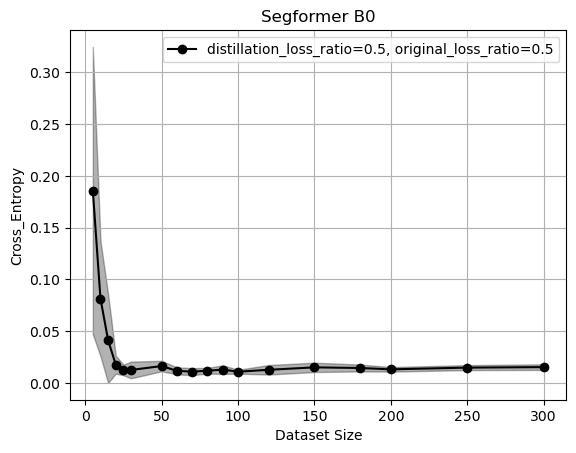

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0604')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.png"))

plt.show()